In [51]:

!pip install google-api-python-client


  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 4.5 MB/s eta 0:00:0000:0100:01
Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl (9.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [google-api-python-client]api-python-client]


# Get latest email

🌐 Launching OAuth consent screen...
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1079069081014-q3a0mc7ir5faadn28gfngcs5baergm92.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A39677%2F&scope=https%3A%2F%2Fmail.google.com%2F&state=W8E8EkqrEwxZ84hRsDJG379hu5pwR3&access_type=offline&prompt=consent
✅ Auth complete
Valid: True
Expired: False
Refresh token: True


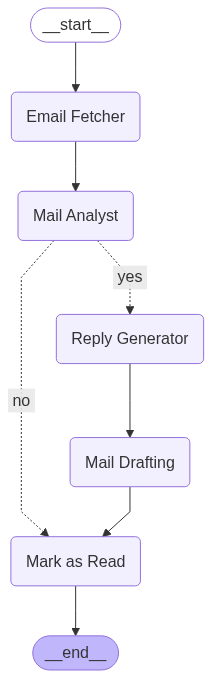

In [17]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

from utils.login import _get_credentials
from utils.email_utils import read_message
from googleapiclient.discovery import build
# from utils.llm_agents import llm_response
import pandas as pd
import json
import getpass
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing import Optional
from pydantic import BaseModel, Field
import requests
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='mail.log', encoding='utf-8', level=logging.INFO)
import base64
from email.message import EmailMessage
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

load_dotenv(override=True)
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
reply_generation_llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

# Pydantic
class EmailReply(BaseModel):
    reply_required: bool = Field(description="Tell if reply is required for the email or not")
    reply_reason: str = Field(description="Tell why the reply is required for the email  if required ")
class GenerateReply(BaseModel):
    generated_reply: str = Field(description="Reply for the given email content")
# structured_llm = llm.with_structured_output(EmailReply)


# Request all access (permission to read/send/receive emails, manage the inbox, and more)
SCOPES = ['https://mail.google.com/']
creds = _get_credentials()
service = build("gmail", "v1", credentials=creds)






class State(TypedDict):
    # email_to_process: int
    messages: Annotated[list, add_messages]
    reply_required: bool
    reply_reason: str
    email_content:str
    message_id:str
    generated_reply:str
    email_from_id:str
    thread_id:str




def get_email_content(state: State):
    'Fetch the latest unread email and return if reply is required or not'
    # print(email_to_process)
    msgs = service.users().messages().list(
                userId='me',
                labelIds=['UNREAD'],
                maxResults=1,  # or however many you want
                # q=query
            ).execute()

    message = msgs['messages'][0]
    email_content,email_from_id,subject = read_message(service, message)
    return {'email_content':email_content[:1000],'email_from_id':email_from_id,
    'thread_id':message['threadId'],'message_id':message['id']}

structured_llm = llm.with_structured_output(EmailReply)
reply_generation_llm = reply_generation_llm.with_structured_output(GenerateReply)
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

def email_agent(state: State):
    # print('###',state['email_content'],'###')
    prompt =f"You are an expert in analysing emails and deciding if they require a reply or not. Email Content \n{state['email_content']}"
    # print(prompt)
    reply_status = structured_llm.invoke(prompt)
    print(reply_status)
    return {'reply_required':reply_status.reply_required,'reply_reason':reply_status.reply_reason}

def generate_reply_agent(state:State):
    prompt=f"Generate a short reply for the given email content \n {state['email_content']}"
    reply = reply_generation_llm.invoke(prompt)
    return {'generated_reply':reply.generated_reply}

def draft_reply_agent(state: State):
    """Draft a reply email to a specific Gmail message.pass in the MESSAGE_ID,REPLY_BODY,email_from_id"""
    logger.info(f"INSIDE DRAFT TOOL To - {state['email_from_id']}")
    # logger.info('Reading INSTRUCITIONS')
    creds = _get_credentials()
    service = build("gmail", "v1", credentials=creds)

    # try:
        # Get original message metadata
    original = service.users().messages().get(
        userId='me',
        id=state['message_id'],
        format='metadata',
        metadataHeaders=['Subject', 'References', 'Message-ID']
    ).execute()

    headers = {h['name']: h['value'] for h in original['payload']['headers']}

    # Compose the reply message
    message = EmailMessage()
    message.set_content(state['generated_reply'])

    message["To"] =state['email_from_id']
    message["From"] = "me"
    message["Subject"] = f"Re: {headers.get('Subject')}"
    if headers.get("References"):
        message["References"] = headers.get("References")
    if headers.get("Message-ID"):
        message["In-Reply-To"] = headers.get("Message-ID")

    # Encode message
    encoded_message = base64.urlsafe_b64encode(message.as_bytes()).decode()

    # Create the draft with proper structure
    draft_body = {
        "message": {
            "raw": encoded_message,
            "threadId": original["threadId"]
        }
    }

    # Create the draft
    draft = service.users().drafts().create(userId='me', body=draft_body).execute()
    print(f"✅ Draft reply created with ID: {draft['id']}")

    # except HttpError as error:
    #     print(f"❌ API error: {error}")
    # except Exception as e:
    #     print(f"❌ General error: {e}")

def route(state:State):
    print('###',state['reply_required'],'###')
    if state['reply_required']:
        return 'yes'
    return 'no'

def mark_read_agent(state:State):
    """
    Function to mark an email as read. Pass in the THREAD_ID,email summary , reply summay.
    """
    logger.info("INSIDE MARK AS READ TOOL")
    print("INSIDE MARK AS READ TOOL")
    credentials=_get_credentials()
    headers = {
        "Authorization": f"Bearer {credentials.token}"
    }
    modify_url = f"https://gmail.googleapis.com/gmail/v1/users/me/threads/{state['thread_id']}/modify"
    response  = requests.post(modify_url, headers=headers,json = {'removeLabelIds': ['UNREAD']})
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("Email Fetcher", get_email_content) #fetch email and tell is reply is required or not
graph_builder.add_node("Mail Analyst", email_agent) #fetch email and tell is reply is required or not
graph_builder.add_node("Reply Generator", generate_reply_agent) # drafts the reply
graph_builder.add_node("Mail Drafting", draft_reply_agent) # drafts the reply
graph_builder.add_node("Mark as Read", mark_read_agent) # marks as read

# Add edges to connect nodes
graph_builder.add_edge(START, "Email Fetcher")
graph_builder.add_edge('Email Fetcher', "Mail Analyst")
graph_builder.add_conditional_edges(
    "Mail Analyst", route, {"yes": "Reply Generator", "no": 'Mark as Read'}
)
graph_builder.add_edge("Reply Generator", "Mail Drafting")
graph_builder.add_edge("Mail Drafting", "Mark as Read")
graph_builder.add_edge("Mark as Read", END)
graph = graph_builder.compile()
graph

In [19]:
# Define the initial state
initial_state = {"email_to_process": 1}

# Invoke the graph
result = graph.invoke(initial_state)

result

Subject: Reimbursement Request for Travel Expenses – Approval Needed
text/plain ###
text/html ###
Saving HTML to Reimbursement Request for Travel Expenses _ Approval Needed/index.html
reply_required=True reply_reason='The email is a reimbursement request that requires approval from the recipient to initiate the reimbursement process. The sender is also asking if any further information is needed.'
### True ###
✅ Auth complete
Valid: True
Expired: False
Refresh token: True
✅ Draft reply created with ID: r-3312307165353290872
INSIDE MARK AS READ TOOL
✅ Auth complete
Valid: True
Expired: False
Refresh token: True


{'messages': [],
 'reply_required': True,
 'reply_reason': 'The email is a reimbursement request that requires approval from the recipient to initiate the reimbursement process. The sender is also asking if any further information is needed.',
 'email_content': 'THREAD_ID: 1980a0c8cc884636 \nMESSAGE_ID: 1980a0c8cc884636\nFrom: Harjaspreet Singh <harjaspreet.s@tatrasdata.com>\nDate: Mon, 14 Jul 2025 23:17:19 +0530\nSubject: Reimbursement Request for Travel Expenses – Approval Needed\nTo: Harjaspreet Singh <singh.harjas2002@gmail.com>\n----- index.html -----\nI hope this message finds you well.\nI am writing to request approval for a reimbursement related to my recent work trip to Bengaluru on July 8th–10th, 2025. The expenses incurred were primarily for transportation and accommodation while attending the client meeting on behalf of our team.\nPlease find the breakdown of the expenses below:\nFlight tickets (round-trip): ₹8,200\nHotel stay (2 nights): ₹6,000\nLocal travel (cabs): ₹1,150